In this project, we will be implementing a logistic regression model and a fully-connected neural network to predict the category of crimes in Calgary's communities based on several other input features.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

In [2]:
# Mount google drive to access the datafile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_orig = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reduced_version_data.csv')
df = df_orig.copy()
df.head()

,Sector,Community Name,Group Category,Category,Crime Count,Resident Count,Year,Month
0,NORTHEAST,WHITEHORN,Crime,Street Robbery,1,12019,2019,SEP
1,EAST,FOOTHILLS,Crime,Theft OF Vehicle,10,317,2019,NOV
2,SOUTH,ACADIA,Crime,Theft FROM Vehicle,13,10520,2019,SEP
3,SOUTHEAST,MAHOGANY,Crime,Theft OF Vehicle,1,11784,2019,NOV
4,WEST,LINCOLN PARK,Crime,Commercial Break & Enter,5,2617,2019,NOV


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Sector          100000 non-null  object
 1   Community Name  100000 non-null  object
 2   Group Category  100000 non-null  object
 3   Category        100000 non-null  object
 4   Crime Count     100000 non-null  int64 
 5   Resident Count  100000 non-null  int64 
 6   Year            100000 non-null  int64 
 7   Month           100000 non-null  object
dtypes: int64(3), object(5)
memory usage: 6.1+ MB


We see that there are no NaN values in the data, so we will likely not have to impute any values.

In [5]:
df['Community Name'].value_counts()

BELTLINE                    782
DOWNTOWN COMMERCIAL CORE    752
FOREST LAWN                 720
MARLBOROUGH                 686
FALCONRIDGE                 677
                           ... 
09P                           3
MEDICINE HILL                 2
05G                           2
03C                           2
05F                           1
Name: Community Name, Length: 300, dtype: int64

For the Community Name variable, I tried a frequency encoding as well as a one-hot encoding on the most common values while mapping the least common values to a single 'Other' category.  The latter worked best for the linear model in Assignment 2, however, for this logistic regression model, I found that a one-hot encoding on all values in this category worked best.

In [6]:
# # Frequency Encoding
# frequencies = df['Community Name'].value_counts()/len(df)
# df["Community Name"] = df["Community Name"].map(lambda name: frequencies[name])

# # One-Hot encoding of top 80 most common communities
# top = df['Community Name'].value_counts()[:80].index
# df.loc[~df['Community Name'].isin(top), 'Community Name'] = 'Other'
# df = pd.get_dummies(df, columns=['Community Name'])

# Full one-hot encoding
df = pd.get_dummies(df, columns=['Community Name'])

In [7]:
df['Group Category'].value_counts()

Crime       64885
Disorder    35115
Name: Group Category, dtype: int64

As there are only 2 values here, we will map Crime to 1 and Disorder to 0.

In [8]:
df['Group Category'] = df['Group Category'].map({'Disorder': 0, 'Crime': 1})

The next feature, Resident Count, is numerical, so lets look at its distribution with a violin plot.

Text(0.5, 1.0, 'Distribution of Resident Count feature')

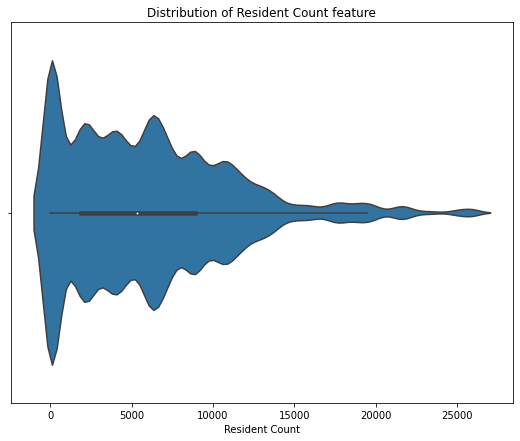

In [9]:
plt.figure(figsize=(9, 7))
sns.violinplot(data=df, x='Resident Count')
plt.title('Distribution of Resident Count feature')
# plt.savefig('resident.png', dpi=300)

In [10]:
df.skew(numeric_only=True)['Resident Count']

1.0484746095288129

We see that this feature is skewed, with a high proportion of zeros.  A square root transformation may help reduce the skewness.

Text(0.5, 1.0, 'Distribution of square root of the Resident Count feature')

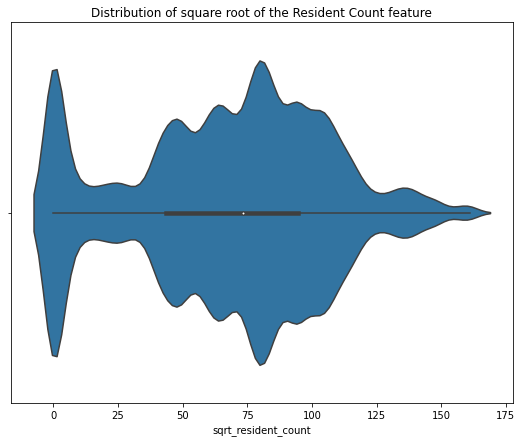

In [11]:
df['sqrt_resident_count'] = np.sqrt(df['Resident Count'])
df = df.drop(columns='Resident Count')
plt.figure(figsize=(9, 7))
sns.violinplot(data=df, x='sqrt_resident_count')
plt.title('Distribution of square root of the Resident Count feature')
# plt.savefig('sqrt_resident.png', dpi=300)

In [12]:
df.skew(numeric_only=True)['sqrt_resident_count']

-0.22059764989237376

This transformed distribution is less skewed and better for our model.

In [13]:
df.Year.value_counts()

2018    15566
2017    15222
2016    14727
2015    14654
2019    12966
2014    11731
2013    10235
2012     4899
Name: Year, dtype: int64

This feature looks fine.  We will leave it as is and normalize later.

In [14]:
df["Crime Count"].value_counts()

1      34097
2      17706
3      10601
4       7112
5       4694
       ...  
631        1
410        1
572        1
248        1
447        1
Name: Crime Count, Length: 343, dtype: int64

Text(0.5, 1.0, 'Distribution of Crime Count feature')

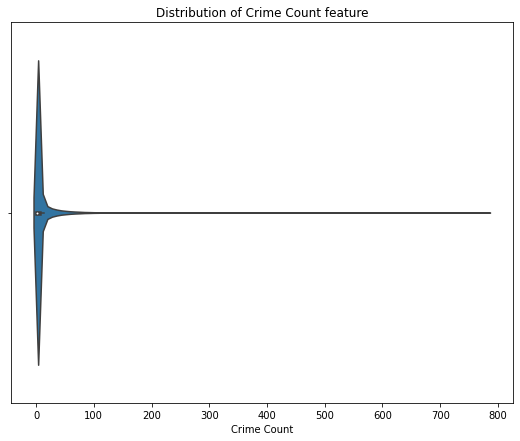

In [15]:
plt.figure(figsize=(9, 7))
sns.violinplot(data=df, x='Crime Count')
plt.title('Distribution of Crime Count feature')
# plt.savefig('crime.png', dpi=300)

In [16]:
df.skew(numeric_only=True)['Crime Count']

14.80602608793062

This variable is highly skewed, so we should apply a transformation to reduce its skew.  From testing, I found applying a logarithmic transform followed by a square root transform produced the best results.  Thus we apply that here.

Text(0.5, 1.0, 'Transformed Crime Count Feature')

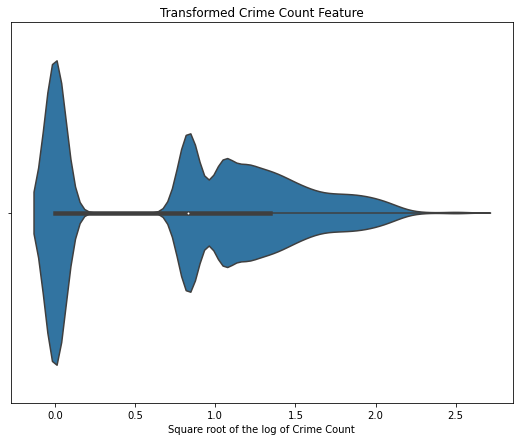

In [17]:
df['sqrt_log_crime_count'] = np.sqrt(np.log(df['Crime Count']))
df = df.drop(columns='Crime Count')
plt.figure(figsize=(9, 7))
sns.violinplot(data=df, x='sqrt_log_crime_count')
plt.xlabel('Square root of the log of Crime Count')
plt.title('Transformed Crime Count Feature')
# plt.savefig('sqrt_log_crime.png', dpi=300)

In [18]:
df.skew(numeric_only=True)['sqrt_log_crime_count']

-0.00043440812040819443

As you can see from the above, this significantly reduces the skewness of the dataset.

In [19]:
df.Sector.value_counts()

CENTRE       25386
SOUTH        16359
NORTHEAST    16336
NORTHWEST    10094
WEST          8918
NORTH         8325
EAST          7927
SOUTHEAST     6655
Name: Sector, dtype: int64

In [20]:
df.Month.value_counts()

OCT    9473
AUG    9451
SEP    9326
NOV    9053
DEC    8893
MAY    8220
APR    7970
MAR    7824
JUL    7782
JAN    7679
FEB    7481
JUN    6848
Name: Month, dtype: int64

For the Month and Sector features we will apply a $\sin-\cos$ encoding whereby we map these values to the unit circle and apply $\sin$ and $\cos$ functions to create two new features. This allows us to preserve the cyclic structure of the variable.  This did not work well for the linear model in the last assignment, but it seems to work at least as well as other encodings in this model.

In [21]:
# sin-cos encoding
angles = {'EAST': 0,
          'NORTHEAST': np.pi/4, 
          'NORTH': np.pi/2,
          'NORTHWEST': 3*np.pi/4,
          'WEST': np.pi,
          'SOUTHWEST': 5*np.pi/4,
          'SOUTH': 3*np.pi/2,
          "SOUTHEAST": 7*np.pi/4}
df['sector_sin'] = [np.sin(angles[sector]) if sector != 'CENTRE' else 0 for sector in df.Sector]
df['sector_cos'] = [np.cos(angles[sector]) if sector != 'CENTRE' else 0 for sector in df.Sector]
df = df.drop(columns='Sector')

In [22]:
# sin-cos encoding
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_angles = {month: i*np.pi/6 for i , month in enumerate(months)}
df['month_sin'] = np.sin([month_angles[month] for month in df.Month])
df['month_cos'] = np.cos([month_angles[month] for month in df.Month])
df = df.drop(columns='Month')

# # Ordinal encoding
# months = dict(zip(months, range(len(months))))
# df.Month = df.Month.map(months)

In [23]:
# # Analyze correlations of variables (except the one-hot encoded ones from the "Community Name" feature)
# df_corr = df[df.columns[~df.columns.str.startswith('Community')]]
# corr = df_corr.corr()
# plt.figure(figsize=(13,11))
# sns.heatmap(corr, annot=True)

In [24]:
df.Category.value_counts()

Social Disorder                  20635
Theft FROM Vehicle               15464
Physical Disorder                14480
Theft OF Vehicle                 12212
Residential Break & Enter        10900
Commercial Break & Enter          9081
Assault (Non-domestic)            7988
Violence Other (Non-domestic)     5398
Street Robbery                    2316
Commercial Robbery                1525
1320.131                             1
Name: Category, dtype: int64

With only one sample corresponding to the "1320.131" class, we will not be able to classify samples corresponding to this label accurately, so we will lump the sample in with another class.  On the Criminal Code of Canada website, we find that 1320.131 corresponds to "Dangerous operation of a motor vehicle".  We will consider this similar to violence and lump it in with the "Violence Other (Non-domestic)" class.

In [25]:
valid_classes = df.Category.value_counts().index[:-1]
df.loc[df[~df.Category.isin(valid_classes)].index.values, 'Category'] = 'Violence Other (Non-domestic)'

Now we split the dataset into training and testing sets.

In [26]:
y = df['Category']
x = df.drop(columns='Category')
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)

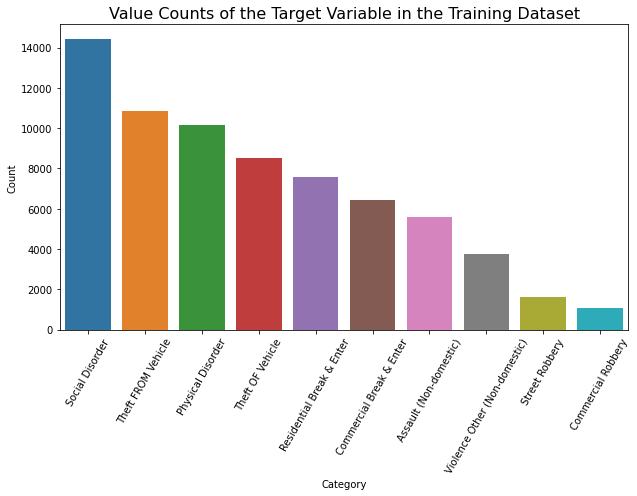

In [27]:
vc = y_train.value_counts()

plt.figure(figsize=(9, 7))
sns.barplot(x=vc.index, y=vc.values)
plt.xticks(rotation=60)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of the Target Variable in the Training Dataset', fontsize=16)
plt.tight_layout()
# plt.savefig('category_train.png', dpi=300)

From the bar plot, we see that some classes in the Category variable correspond to far more samples than others.  This is an issue as the classifier learns to assign the classes that occur more frequently to new samples simply because the classifier has seen more of them in training.  To remedy this, we can compute weights for each of the classes and pass them into `sklearn.linear_model.LogisticRegression` to balance the classes during training.

In [28]:
class_weights = vc.sum() / (len(vc) * vc)
class_weights /= class_weights.sum()
class_weights = dict(class_weights)

Before we fit our classifier, we should normalize our input data.

In [29]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Now we define and fit our classifier.

In [30]:
lr = LogisticRegression(class_weight=class_weights, max_iter=500, tol=1e-6, multi_class='multinomial')
lr.fit(x_train, y_train)

LogisticRegression(class_weight={'Assault (Non-domestic)': 0.06743743625035992,
                                 'Commercial Break & Enter': 0.058805360297515284,
                                 'Commercial Robbery': 0.3476291068647585,
                                 'Physical Disorder': 0.03705448285177945,
                                 'Residential Break & Enter': 0.0497661407769182,
                                 'Social Disorder': 0.026134810209829756,
                                 'Street Robbery': 0.23325762581834447,
                                 'Theft FROM Vehicle': 0.034785352849604635,
                                 'Theft OF Vehicle': 0.04428006350648779,
                                 'Violence Other (Non-domestic)': 0.10084962057440187},
                   max_iter=500, multi_class='multinomial', tol=1e-06)

In [31]:
# Predict results
train_pred = lr.predict(x_train)
test_pred = lr.predict(x_test)

In [32]:
# Compute accuracy
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

In [33]:
print(f'Training accuracy: {train_acc:.2%}')
print(f'Testing accuracy: {test_acc:.2%}')

Training accuracy: 51.83%
Testing accuracy: 50.13%


Now we will look more in-depth at the results with a confusion matrix.

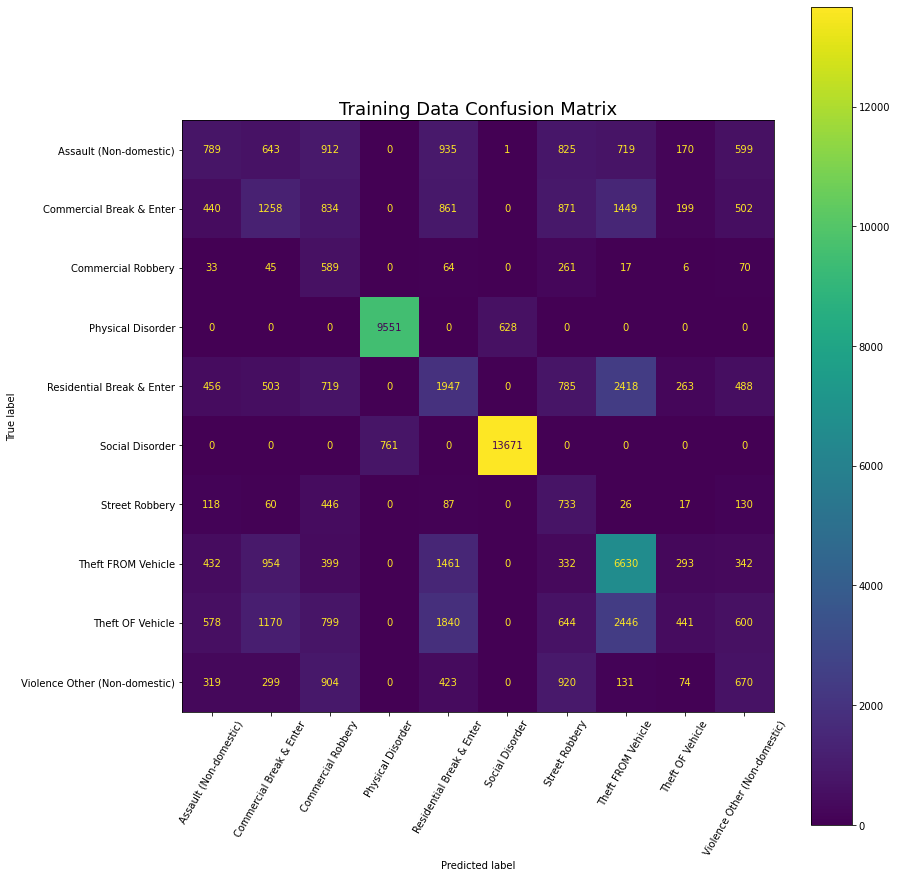

In [34]:
plt.figure(figsize=(13, 13))
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(y_train, train_pred, ax=ax)
plt.xticks(rotation=60)
plt.title('Training Data Confusion Matrix', fontsize=18)
plt.tight_layout()
# plt.savefig('log_train_cm.png', dpi=300)

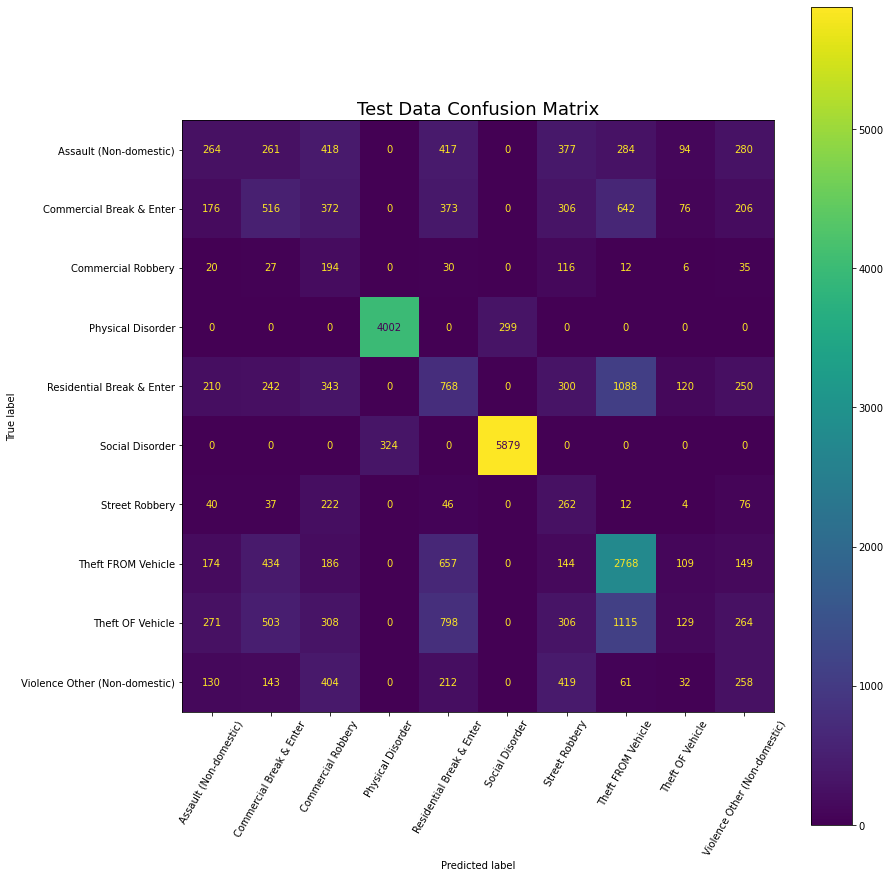

In [35]:
plt.figure(figsize=(13, 13))
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, ax=ax)
plt.xticks(rotation=60)
plt.title('Test Data Confusion Matrix', fontsize=18)
plt.tight_layout()
# plt.savefig('log_test_cm.png', dpi=300)

From the accuracies printed above and the confusion matrices, it is obvious this classifier is rather poor and produces many misclassifications. Let's see if we can do better with a fully-connected network.


In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Softmax
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

I will redo the preliminary data manipulation here as there are a few changes I will make.

In [37]:
df = df_orig.copy()


# Frequency Encoding of Community Name
frequencies = df['Community Name'].value_counts()/len(df)
df["Community Name frequency"] = df["Community Name"].map(lambda name: frequencies[name])

# Full one-hot encoding of Community Name
df = pd.get_dummies(df, columns=['Community Name'])


# Binary encoding of the Group Category
df['Group Category'] = df['Group Category'].map({'Disorder': 0, 'Crime': 1})


# Transform the Resident Count variable to unskew the distribution
df['sqrt_resident_count'] = np.sqrt(df['Resident Count'])
# df = df.drop(columns='Resident Count')


# Apply a transform to the Crime Count variable as well
df['sqrt_log_crime_count'] = np.sqrt(np.log(df['Crime Count']))
# df = df.drop(columns='Crime Count')


# sin-cos encoding for the Sector
angles = {'EAST': 0,
          'NORTHEAST': np.pi/4, 
          'NORTH': np.pi/2,
          'NORTHWEST': 3*np.pi/4,
          'WEST': np.pi,
          'SOUTHWEST': 5*np.pi/4,
          'SOUTH': 3*np.pi/2,
          "SOUTHEAST": 7*np.pi/4}
df['sector_sin'] = [np.sin(angles[sector]) if sector != 'CENTRE' else 0 for sector in df.Sector]
df['sector_cos'] = [np.cos(angles[sector]) if sector != 'CENTRE' else 0 for sector in df.Sector]
df = df.drop(columns='Sector')


# sin-cos encoding for the Month
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_angles = {month: i*np.pi/6 for i , month in enumerate(months)}
df['month_sin'] = np.sin([month_angles[month] for month in df.Month])
df['month_cos'] = np.cos([month_angles[month] for month in df.Month])
df = df.drop(columns='Month')


# Lump the odd class in with the Violence Other class
valid_classes = df.Category.value_counts().index[:-1]
df.loc[df[~df.Category.isin(valid_classes)].index.values, 'Category'] = 'Violence Other (Non-domestic)'

Above I applied the same encodings to the data as with the logistic model, however, I included a few more variables as well as they seemed to help with classification accuracy slightly.  Namely, I included both the original and transformed values for the Resident Count and Crime Count variables. Also, I included both a frequency encoding and a one-hot encoding for the Community Name variable.

In [38]:
# Split train and test sets
y = df['Category']
x = df.drop(columns='Category')
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)

# Compute class weights
vc = y_train.value_counts()
class_weights = vc.sum() / (len(vc) * vc)
class_weights /= class_weights.sum()
class_weights = dict(class_weights)

# Normaize the data
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In order to pass class weights into the model, keras requires the weight labels and the classes to be represented as integers instead of strings, so we make the change here.

In [39]:
# Create a map of class labels to integers
class_labels = np.unique(y_train)
class_label_map = dict(zip(class_labels, range(len(class_labels))))

# Apply the map to transform the dictionary of weights and the y-tensors
class_weights = {class_label_map[label]: class_weights[label] for label in class_weights}
y_train_numeric = np.array([class_label_map[label] for label in y_train])
y_test_numeric = np.array([class_label_map[label] if label in class_label_map else -1 for label in y_test])

In [40]:
# Hyperparameters and constants
BATCH_SIZE = 1024
INPUT_SHAPE = (len(x_train[0]),)
EPOCHS = 40
N_CLASSES = len(np.unique(y_train))
LR = 1e-3

Now we define a class representing our fully-connected classifier.

In [41]:
class FCClf(Model):
  def __init__(self):
    super().__init__()

    self.fc1 = Dense(256, activation='tanh')
    self.bn1 = BatchNormalization()
    self.d1 = Dropout(0.3)
    self.fc2 = Dense(128, activation='relu')
    self.bn2 = BatchNormalization()
    self.d2 = Dropout(0.2)
    self.fc3 = Dense(N_CLASSES)
  
  def call(self, x, training=False):
    x = self.fc1(x)
    x = self.bn1(x)
    if training: x = self.d1(x, training=training)
    x = self.fc2(x)
    x = self.bn2(x)
    if training: x = self.d2(x, training=training)
    return self.fc3(x)

In [42]:
fcclf = FCClf()
fcclf.build(input_shape=(BATCH_SIZE, *INPUT_SHAPE))

We will train the model with the Adam optimizer and a cross-entropy loss.  The `SparseCategoricalCrossentropy` class from keras allows us to compute cross-entropy loss without one-hot encoding our class labels before training.  Moreover, we can pass in `from_logits=True` to this class so that we do not have to apply a softmax activation to our last layer.  This allows keras to combine the softmax and loss computations together and apply the [log-sum-exp](https://en.wikipedia.org/wiki/LogSumExp) trick for numerical stability.

In [43]:
fcclf.compile(optimizer=Adam(learning_rate=LR),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
fcclf.fit(x_train, y_train_numeric, batch_size=BATCH_SIZE, epochs=EPOCHS, class_weight=class_weights)

Epoch 1/40
69/69 [==============================] - 4s 5ms/step - loss: 0.1257 - accuracy: 0.2364
Epoch 2/40
69/69 [==============================] - 0s 5ms/step - loss: 0.0953 - accuracy: 0.4046
Epoch 3/40
69/69 [==============================] - 0s 5ms/step - loss: 0.0862 - accuracy: 0.4628
Epoch 4/40
69/69 [==============================] - 0s 5ms/step - loss: 0.0830 - accuracy: 0.4800
Epoch 5/40
69/69 [==============================] - 0s 6ms/step - loss: 0.0813 - accuracy: 0.4908
Epoch 6/40
69/69 [==============================] - 0s 4ms/step - loss: 0.0802 - accuracy: 0.4937
Epoch 7/40
69/69 [==============================] - 0s 6ms/step - loss: 0.0794 - accuracy: 0.4971
Epoch 8/40
69/69 [==============================] - 0s 5ms/step - loss: 0.0788 - accuracy: 0.5004
Epoch 9/40
69/69 [==============================] - 0s 5ms/step - loss: 0.0781 - accuracy: 0.5032
Epoch 10/40
69/69 [==============================] - 0s 5ms/step - loss: 0.0778 - accuracy: 0.5041
Epoch 11/40
69/69 [

In [45]:
fcclf.evaluate(x_test, y_test_numeric)

938/938 [==============================] - 2s 2ms/step - loss: 1.1886 - accuracy: 0.4956


[1.1885985136032104, 0.4956333339214325]

To get predictions, we append the missing softmax activation onto the end of the nework and pass in our input data.

In [46]:
fcclf = Sequential([fcclf, Softmax()])

Taking the argmax of the predictions gives returns the numerical class label associated with the one-hot-like vectors produced by the model.

In [47]:
# Get predictions and revert the one-hot vectors to integers
train_pred = np.argmax(fcclf(x_train), axis=1)
test_pred = np.argmax(fcclf(x_test), axis=1)

Again, let's look at the confusion matrices.

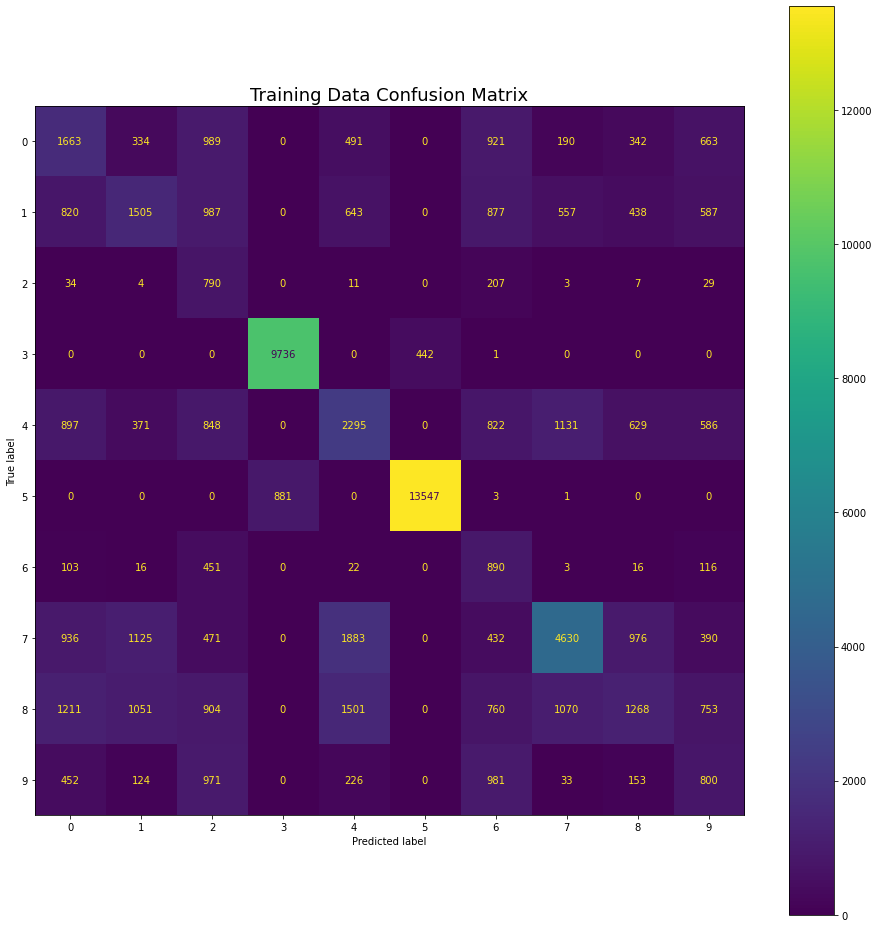

In [48]:
plt.figure(figsize=(13, 13))
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(y_train_numeric, train_pred, ax=ax)
plt.title('Training Data Confusion Matrix', fontsize=18)
plt.tight_layout()
# plt.savefig('nn_train_cm.png', dpi=300)

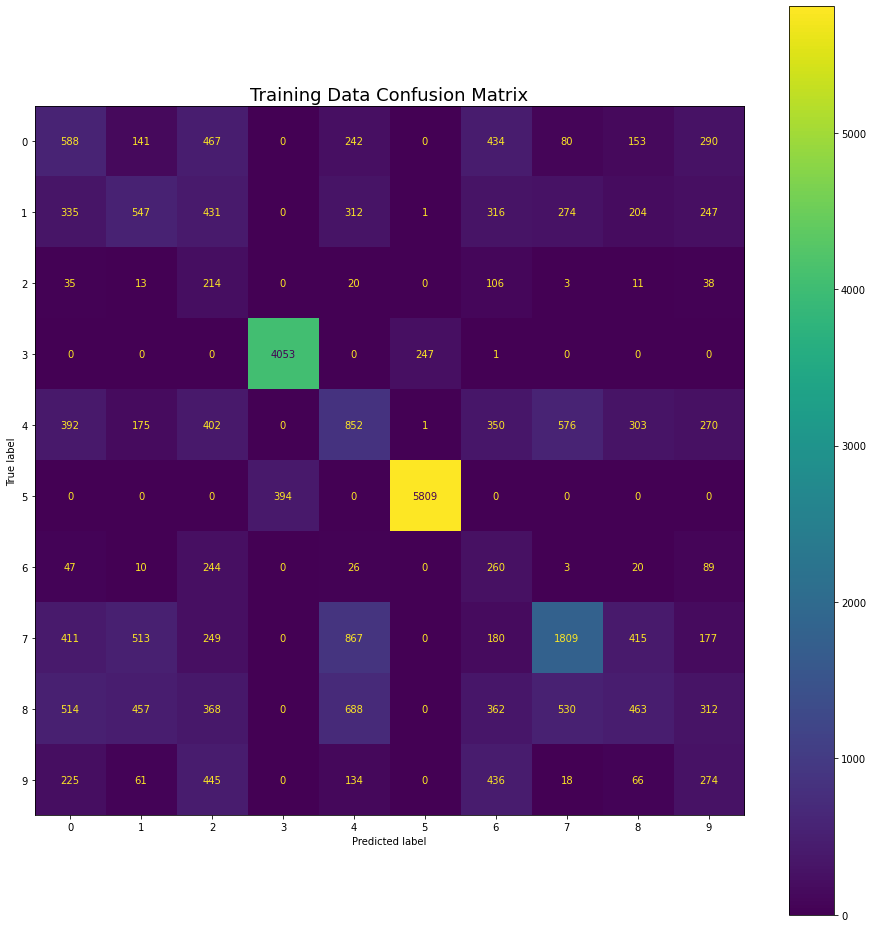

In [49]:
plt.figure(figsize=(13,13))
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(y_test_numeric, test_pred, ax=ax)
plt.title('Training Data Confusion Matrix', fontsize=18)
plt.tight_layout()
# plt.savefig('nn_test_cm.png', dpi=300)

As you can see from the accuracy and confusion matrices, this model also performs quite poorly and similar to the logistic regression model.

The following code finds and prints the number of samples in our dataset for which the exact same set of input data corresponds to multiple class labels.

In [50]:
df = df_orig.copy()
x_cols = ['Sector', 'Community Name', 'Crime Count', 'Group Category', 'Resident Count', 'Month', 'Year']

df['allx'] = df[x_cols[0]]
for col in x_cols[1:]:
  df['allx'] += df[col].astype(str)

df = df.drop(columns=x_cols)

dupx = df.groupby(['allx']).Category.nunique().gt(1)
print('Number of UNIQUE samples that occur more than once in the dataset and correspond to more than one class:', dupx.sum())

n = len(df[df.allx.isin(dupx[dupx].index)])
print('TOTAL number of samples that occur more than once in the dataset and correspond to more than one class:', n)

Number of UNIQUE samples that occur more than once in the dataset and correspond to more than one class: 13743
TOTAL number of samples that occur more than once in the dataset and correspond to more than one class: 31867


As you can see, nearly 32% of the dataset has this property.  It is impossible for any classifier to accurately classify these values as it can only map an input to a single output.  This is likely a large part of the reason for the poor network performance.

In [51]:
df = df_orig.copy()
df = df.drop(columns=['Crime Count'])
x_cols = ['Sector', 'Community Name', 'Group Category', 'Resident Count', 'Month', 'Year']

df['allx'] = df[x_cols[0]]
for col in x_cols[1:]:
  df['allx'] += df[col].astype(str)

df = df.drop(columns=x_cols)

dupx = df.groupby(['allx']).Category.nunique().gt(1)
print('Number of UNIQUE samples (excluding Crime Count variable) that occur more than once in the dataset and correspond to more than one class:', dupx.sum())

n = len(df[df.allx.isin(dupx[dupx].index)])
print('TOTAL number of samples (excluding Crime Count variable) that occur more than once in the dataset and correspond to more than one class:', n)

Number of UNIQUE samples (excluding Crime Count variable) that occur more than once in the dataset and correspond to more than one class: 29643
TOTAL number of samples (excluding Crime Count variable) that occur more than once in the dataset and correspond to more than one class: 88467


If we exclude the Crime Count variable, then this jumps to over 88%!  This means that, for 88% of the data, the classifier only has the Crime Count variable to distinguish between at least 2 classes, which most definitely is not enough for an accurate classification.